# <center> EEG Classification Model

## 1. INTRODUCTION

Electroencephalography (EEG) is a non-invasive neuroimaging procedure that uses electrodes implanted on the scalp to monitor the electrical activity of the brain. These sensors detect and record voltage variations caused by coordinated neuronal firing of large groups of neurons. In clinical settings, EEG is commonly used to diagnose and monitor a variety of neurological illnesses, including epilepsy and sleep problems. Furthermore, it is important in research because it provides useful insights into brain function and activity patterns connected with various cognitive states, emotions, and neurological illnesses. EEG recordings are shown as waveforms called electroencephalograms, which may be studied to learn about brain dynamics and anomalies.

<img src="https://i0.wp.com/www.brightbraincentre.co.uk/wp-content/uploads/2021/05/The-measurement-and-display-of-EEG-on-human-brains-with-electrodes-8.jpg?resize=839%2C550&ssl=1"  width="300" height="300">

Processing EEG data for convolutional neural networks (CNNs) involves a series of steps to transform raw electroencephalogram signals into a format suitable for neural network input. Initial data preprocessing steps include filtering to remove noise and segmentation to break the continuous signal into manageable epochs. Feature extraction encompasses time-domain statistics, frequency-domain components through techniques like Fourier transform, and spatial features to capture electrode distributions. Normalization ensures consistent feature scales, promoting faster convergence during network training. The organized features are then represented in a suitable input format, often 2D matrices reflecting time or frequency on one axis and electrode channels on the other. The CNN is trained to automatically learn hierarchical features and relationships within the EEG data. Classification or regression tasks are performed based on the learned features, making CNNs particularly effective for deciphering complex EEG patterns associated with cognitive states or medical conditions. This approach is pivotal in applications such as brain-computer interfaces and medical diagnosis, offering a powerful tool for understanding intricate brain dynamics and facilitating accurate predictions or classifications in diverse EEG-related domains.

## TABLE OF CONTENTS

1. Introduction
2. Dataset
3. Data Loading

## 2. DATASET

The link for the dataset -> https://physionet.org/content/chbmit/1.0.0/

**Reference/Citation** : Guttag, J. (2010). CHB-MIT Scalp EEG Database (version 1.0.0). PhysioNet. https://doi.org/10.13026/C2K01R.

### 2.1 Abstract

The CHB-MIT Scalp EEG Database, a collection of EEG recordings of 22 pediatric subjects with intractable seizures, is now available. Subjects were monitored for up to several days following withdrawal of anti-seizure medication to characterize seizures and assess their candidacy for surgical intervention. In all, the onsets and ends of 182 seizures are annotated.

This database, collected at the Children’s Hospital Boston, consists of EEG recordings from pediatric subjects with intractable seizures. Subjects were monitored for up to several days following withdrawal of anti-seizure medication in order to characterize their seizures and assess their candidacy for surgical intervention. The recordings are grouped into 23 cases and were collected from 22 subjects (5 males, ages 3–22; and 17 females, ages 1.5–19).


### 2.2 Background

Seizures are temporary deviations in the brain's electrical activity. Individuals with epilepsy, a disorder of the central nervous system, experience recurrent seizures that can happen unpredictably and often without any prior alert. These seizures may lead to a brief loss of attention or a full-body convulsion. Regular occurrence of seizures heightens the risk of physical injuries for the person and could potentially lead to death. A device that can swiftly detect and respond to a seizure by administering treatment or alerting a caregiver could help mitigate the challenges associated with seizures.

This database, collected at the Children’s Hospital Boston, consists of EEG recordings from pediatric subjects with intractable seizures. Subjects were monitored for up to several days following withdrawal of anti-seizure medication in order to characterize their seizures and assess their candidacy for surgical intervention.

## 3. DATA PREPROCESSING

The data is taken from the website above and saved locally. Because the downloaded format is.zip. It's removed and saved in the same place.

In [1]:
# import all the necessary libraries

from glob import glob
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import pyedflib
import mne
import tqdm
import os.path
from scipy.signal import welch,stft
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import euclidean
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils._param_validation import _MissingValues


warnings.filterwarnings("ignore")

In [2]:
# specify the file path of the downloaded files
subject_file_path = r"D:\NEU\Semester 1\FDA\Project\Project 3\chb-mit-scalp-eeg-database-1.0.0\SUBJECT-INFO"
records_file_path = r"D:\NEU\Semester 1\FDA\Project\Project 3\chb-mit-scalp-eeg-database-1.0.0\RECORDS"
record_seizures_file_path = r"D:\NEU\Semester 1\FDA\Project\Project 3\chb-mit-scalp-eeg-database-1.0.0\RECORDS-WITH-SEIZURES"
sample_file_path = r"D:\NEU\Semester 1\FDA\Project\Project 3\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_03.edf"

In [3]:
# Read the data into a pandas DataFrame with the header
subject_data = pd.read_csv(subject_file_path, delimiter='\t')

# Display the DataFrame
print("Subject Details")
subject_data

Subject Details


,Case,Gender,Age (years)
0,chb01,F,11.0
1,chb02,M,11.0
2,chb03,F,14.0
3,chb04,M,22.0
4,chb05,F,7.0
5,chb06,F,1.5
6,chb07,F,14.5
7,chb08,M,3.5
8,chb09,F,10.0
9,chb10,M,3.0


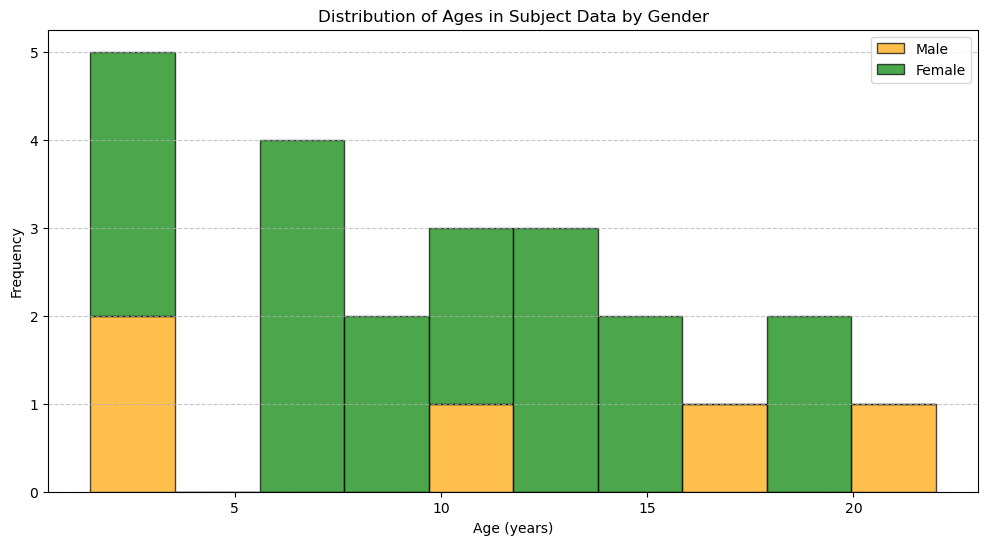

In [4]:
male_data = subject_data[subject_data['Gender'] == 'M']['Age (years)']
female_data = subject_data[subject_data['Gender'] == 'F']['Age (years)']

# Plotting a grouped bar chart
plt.figure(figsize=(12, 6))

plt.hist([male_data, female_data], bins=10, color=['orange', 'green'], 
         edgecolor='black', label=['Male', 'Female'], alpha=0.7, stacked=True)

plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.title('Distribution of Ages in Subject Data by Gender')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [5]:
# Load all the record files in the document as pandas dataframe
records_file = pd.read_csv(records_file_path, header=None, names=['File Path'])
record_seizures_file = pd.read_csv(record_seizures_file_path, header=None, names=['File Path'])

records_file[['Directory', 'File Name']] = records_file['File Path'].str.split('/', 1, expand=True)
records_file.drop('File Path', axis=1, inplace=True)
record_seizures_file[['Directory', 'File Name']] = record_seizures_file['File Path'].str.split('/', 1, expand=True)
record_seizures_file.drop('File Path', axis=1, inplace=True)

records_file['Seizures Data Present'] = records_file.apply(
    lambda row: 'Has Seizure' if (row['Directory'], 
                                  row['File Name']) in zip(record_seizures_file['Directory'],
                                    record_seizures_file['File Name']) else 'No Seizure', axis=1
)

# Display the DataFrame
print("Record File name list")
records_file

Record File name list


,Directory,File Name,Seizures Data Present
0,chb01,chb01_01.edf,No Seizure
1,chb01,chb01_02.edf,No Seizure
2,chb01,chb01_03.edf,Has Seizure
3,chb01,chb01_04.edf,Has Seizure
4,chb01,chb01_05.edf,No Seizure
...,...,...,...
681,chb24,chb24_18.edf,No Seizure
682,chb24,chb24_19.edf,No Seizure
683,chb24,chb24_20.edf,No Seizure
684,chb24,chb24_21.edf,Has Seizure


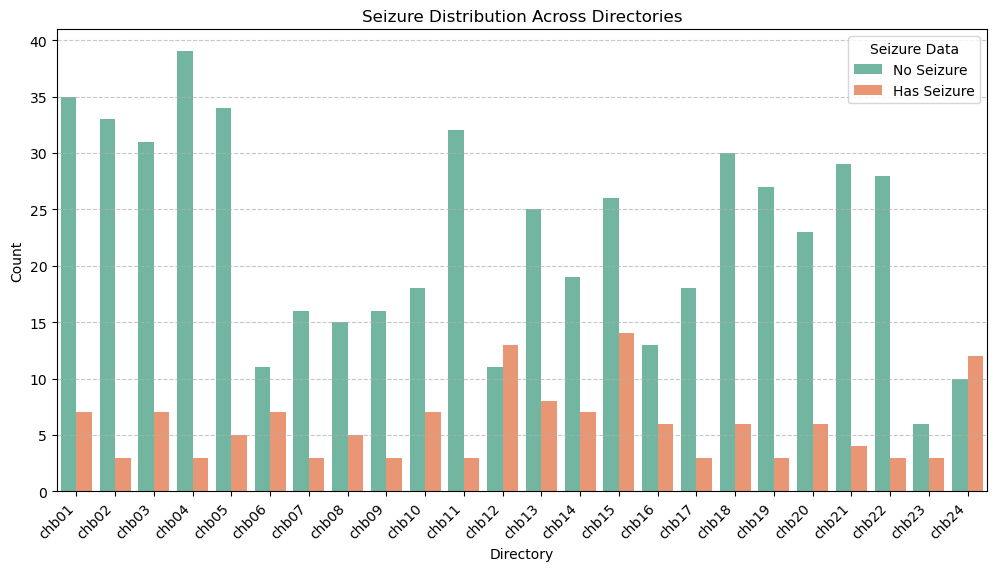

In [6]:
# Plotting a bar chart
plt.figure(figsize=(12, 6))
sns.countplot(x='Directory', hue='Seizures Data Present', data=records_file, palette='Set2')
plt.xlabel('Directory')
plt.ylabel('Count')
plt.title('Seizure Distribution Across Directories')
plt.legend(title='Seizure Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45, ha='right')
# Display the plot
plt.show()

Import the sample data for the EEG file as a sample

In [7]:
sample_file = mne.io.read_raw_edf(sample_file_path, preload=True)

Extracting EDF parameters from D:\NEU\Semester 1\FDA\Project\Project 3\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


Now we plot only the region where the seizure taken place

Effective window size : 8.000 (s)
Using matplotlib as 2D backend.


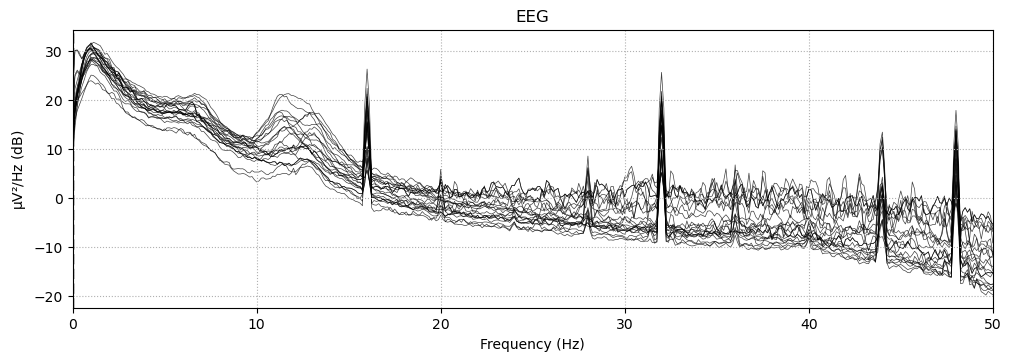

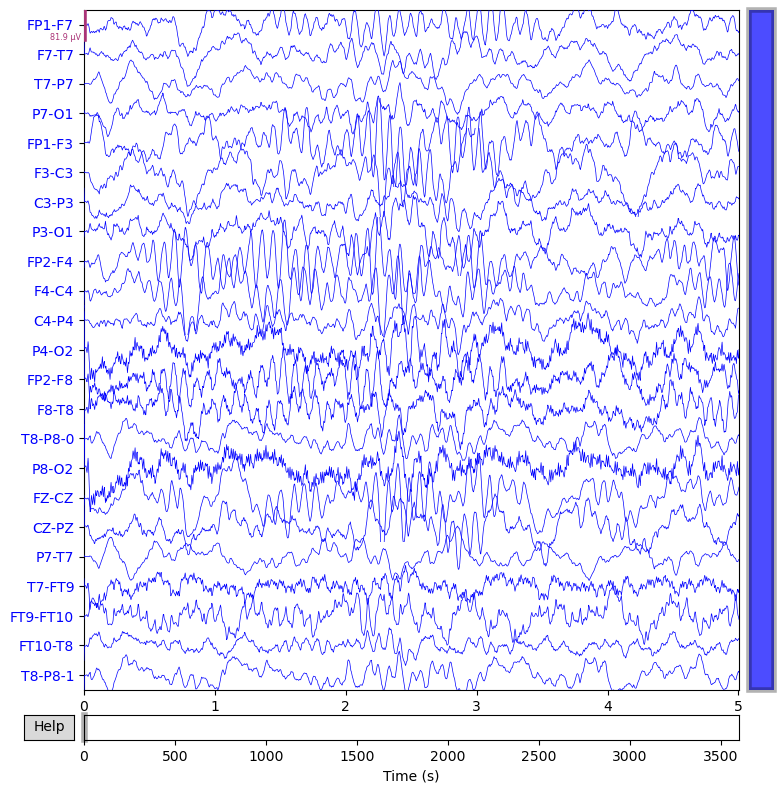

In [8]:
# Plot the power spectral density without amplitude (frequency plot) with a specific color
psd_fig = sample_file.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False, color='green')
#psd_fig.set_title('Power Spectral Density')

# Plot the raw EEG data with a different color for each channel
sample_file.plot(duration=5, n_channels=30, color='blue', scalings='auto')
plt.show()

For the above sample file the sample has seizure on seizure start time in 2996 seconds and seizure end time in 3036. Now plotting graphs for the specific frequency

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    1.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    2.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    2.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.1s finished


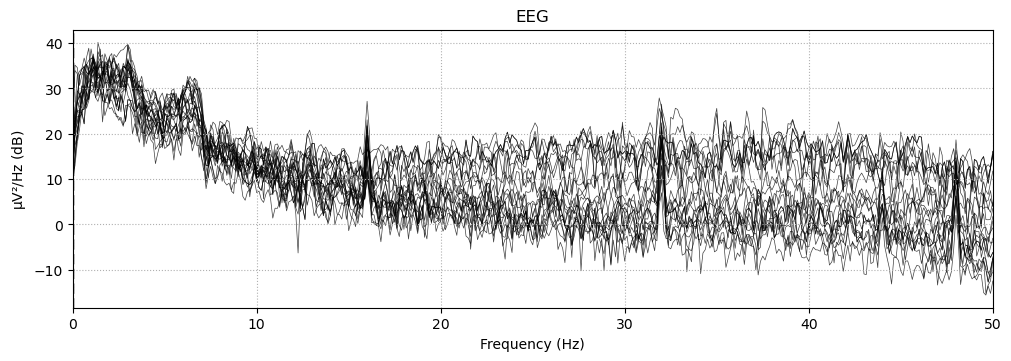

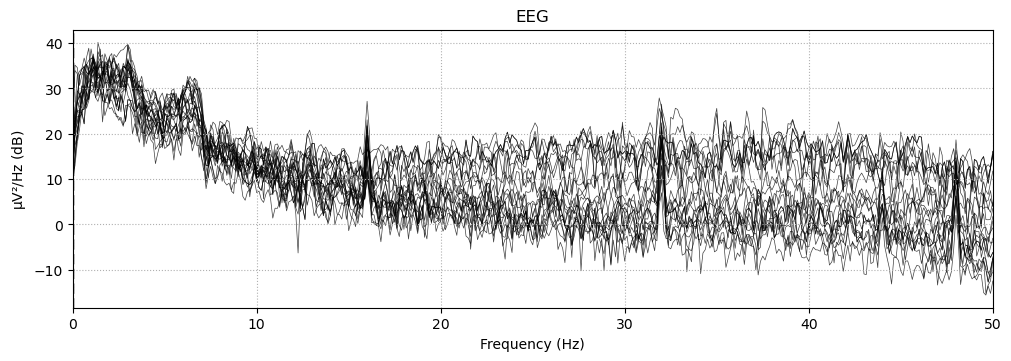

In [9]:
seizure_start_time = 2996
seizure_end_time = 3036

# Plot the power spectral density for the entire signal with a focus on the seizure interval
sample_file.plot_psd(fmax=50, n_jobs=-1, tmin=seizure_start_time, tmax=seizure_end_time, show=True)

## 4. Feature Extraction

**Time-Domain Feature Extraction**

Time-domain feature extraction is essential in signal processing as it provides a succinct representation of a signal's characteristics in its raw temporal form. These features, such as mean, standard deviation, skewness, and kurtosis, offer interpretable insights into a signal's central tendency, variability, and distribution shape. Their computational efficiency makes them suitable for real-time applications and machine learning tasks, where quick and meaningful analyses are crucial. In domains like biomedical signal processing, time-domain features play a vital role in disease diagnosis and monitoring, offering valuable information about physiological signals.

In [10]:
def extract_basic_features(signal):
    # Standardise the signal
    signal = (signal - np.mean(signal)) / np.std(signal)
    # Determine the fundamental statistical characteristics
    mean = np.mean(signal)
    std = np.std(signal)
    sample_entropy = np.log(np.std(np.diff(signal)))
    fuzzy_entropy = -np.log(euclidean(signal[:-1], signal[1:]) / len(signal))
    skewness = skew(signal)
    kurt = kurtosis(signal)
    return [mean, std, sample_entropy, fuzzy_entropy, skewness, kurt]

**Frequency-Domain Feature Extraction**


Frequency domain feature extraction is vital for identifying distinct patterns and periodic behaviors in signals. It characterizes signal dynamics, aids in noise analysis, and improves signal classification through spectral content. Particularly crucial in biomedical signal processing, it helps diagnose and monitor medical conditions. In communication systems, frequency domain analysis is essential for modulation, demodulation, and filtering operations. Overall, it provides a comprehensive understanding of signal characteristics, enabling efficient data compression and handling non-stationary signals.

The brief-Time Fourier Transform (STFT) is a time-frequency analysis technique that reveals a signal's frequency content across brief, overlapping time segments. STFT gives a time-varying representation of a signal's spectral content by applying the Fourier Transform to consecutive windows of a signal. This allows for the investigation of non-stationary signals and records how the frequencies of the signal fluctuate over time. STFT is commonly utilized in signal processing applications including audio and voice processing.

In [11]:
#Use the Short-Time Fourier Transform to extract advanced features from EEG data (STFT).

def extract_advanced_features(data, fs, window_length_sec=3):
    
    #This code determines the average power for every frequency band in order to keep things simple.
    f, t, Zxx = stft(data, fs, nperseg=window_length_sec * fs)
    
    #The average squared amplitude of the STFT is calculated to achieve this.
    power = np.mean(np.abs(Zxx)**2, axis=1)  # Average power at each frequency

    return power

The function preprocesses EEG data from an EDF file using MNE-Python. It applies a band-pass filter, selects EEG channels, and defines a brief time window. For each window, it extracts basic and advanced features from each EEG channel, combining them with timestamps. The resulting array contains timestamped features for further analysis.

In [12]:
def preprocess_and_extract_features_mne_with_timestamps(file_name):

    # Load data
    raw = mne.io.read_raw_edf(file_name, preload=True)

    # Applying band-pass filter
    raw.filter(1., 50., fir_design='firwin')

    # Selecting EEG channels
    raw.pick_types(meg=False, eeg=True, eog=False)

    # Establish the parameters for the brief window of time.    
    window_length = 3  # Window length (seconds)
    sfreq = raw.info['sfreq']  # Sampling frequency
    window_samples = int(window_length * sfreq)

    # To store features and timestamps initialize an empty list
    features_with_timestamps = []

    # Iterate through data in each window
    for start in range(0, len(raw.times), window_samples):
        end = start + window_samples
        if end > len(raw.times):
            break

        # Use this window to extract and preprocess data.
        window_data, times = raw[:, start:end]
        window_data = np.squeeze(window_data)

        # Get the start timestamp of the window
        timestamp = raw.times[start]

        #Extract each channel's basic and advanced features from each window.
        for channel_data in window_data:
            basic_features = extract_basic_features(channel_data)
            advanced_features = extract_advanced_features(channel_data, sfreq)
            combined_features = np.concatenate([[timestamp], basic_features, advanced_features])
            features_with_timestamps.append(combined_features)

    return np.array(features_with_timestamps)

The function takes paths to a summary file and an EDF file, extracts the EDF file name, and searches for seizure information within the summary file. It iterates through the summary file, identifies the relevant lines based on the EDF file name, and extracts seizure start and end times if available. The function returns the seizure start time and end time, or None if no seizures are present in the file.

In [13]:
def extractTarget(summary_file_path, edf_file_path):
    # Extract the file name from the full path
    edf_file_name = os.path.basename(edf_file_path)
    
    # To store seizure start time and end time initialize variables
    seizure_start_time = None
    seizure_end_time = None
    
    # Start the summary text file and read it.
    with open(summary_file_path, 'r') as file:
        lines = file.readlines()
    
    # Flag to show if a file name that matches is located
    found = False
    
    # Go through every line in the file once.
    for line in lines:
        if "File Name: " + edf_file_name in line:
            found = True
        if found:
            # Return None immediately if there are no seizures.
            if "Number of Seizures in File: 0" in line:
                return None, None
            # Extract seizure start time if present
            if "Seizure Start Time:" in line:
                seizure_start_time = int(line.split(": ")[1].split(" ")[0])
            #Extract the end of the seizure if it exists, then close the loop.
            if "Seizure End Time:" in line:
                seizure_end_time = int(line.split(": ")[1].split(" ")[0])
                break
    
    return seizure_start_time, seizure_end_time


extract_data_and_labels extracts features and labels from EEG data by calling preprocess_and_extract_features_mne_with_timestamps and extractTarget functions. It preprocesses EEG data to obtain features and determines labels based on seizure information in the summary file. The function returns the features array (X) and labels array (y).

The load_data function loads EEG data for a given subject ID, reading all associated EDF files and their corresponding summary file. It iterates through each EDF file, extracting features and labels using extract_data_and_labels. The resulting features and labels for all files are returned as lists (all_X and all_y).

In [14]:
import glob
import os.path
import numpy as np


def extract_data_and_labels(edf_file_path, summary_file_path):

    #Extract Features
    X = preprocess_and_extract_features_mne_with_timestamps(edf_file_path)
    #Extract Labels
    seizure_start_time, seizure_end_time = extractTarget(summary_file_path, edf_file_path)
    if not seizure_start_time and not seizure_end_time:
        seizure_start_time = -1
        seizure_end_time = 100000000000
    y = np.array([1 if seizure_start_time <= row[0] <= seizure_end_time else 0 for row in X])

    #removing column time from x array
    X = X[:,1:]
    return X,y


def load_data(base_path):
    
    all_X = []
    all_y = []

    # Get a list of all subdirectories (assuming they follow the format "chb{:02d}")
    subject_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d)) and d.startswith("chb")]

    for subject_dir in subject_dirs:
        subject_id = int(subject_dir[3:])  # Extract subject ID from the directory name
        edf_file_path = sorted(glob.glob(os.path.join(base_path, subject_dir, "*.edf")))
        summary_file_path = os.path.join(base_path, subject_dir, "{}-summary.txt".format(subject_dir))

        for edf_file_path in edf_file_path:
            X, y = extract_data_and_labels(edf_file_path, summary_file_path)
            all_X.append(X)
            all_y.append(y)

    return all_X, all_y

## 5. Machine Learning Models

In [15]:
%%capture
base_path = r"D:\NEU\Semester 1\FDA\Project\Project 3\Testing"
all_X,all_y = load_data(base_path)

print(all_X)

### Decision Tree Classifier

In [17]:
import numpy as np


#from src.data.loaddata import load_data

'''subject_id = 1
base_path = "data"
all_X,all_y = load_data(subject_id,base_path)'''

#Merge all_X and all_y
X = np.vstack(all_X)
y = np.concatenate(all_y)
smote = SMOTE() #Initialize SMOTE instance
# Apply SMOTE oversampling
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the processed datase
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)

#Training Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

#Predict on the test set
y_pred = clf.predict(X_test)

#Evaluate the model
print("Decision Tree")
dt_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", dt_accuracy)

#cal F1 score
dt_f1 = f1_score(y_test, y_pred)
print(f"F1_score: {dt_f1}")

Decision Tree
Accuracy: 0.6019900995049753
F1_score: 0.5974979520423952


In [18]:
#from sklearn.metrics import confusion_matrix
plt.figure(figsize=(12, 6))

def plot_accuracy_graph(history):
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

'''
# Confusion matrix
y_pred = (y_pred_proba > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()
'''

"\n# Confusion matrix\ny_pred = (y_pred_proba > 0.5).astype(int)\nconf_matrix = confusion_matrix(y_test, y_pred)\n\nplt.figure(figsize=(8, 6))\nsns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,\n            xticklabels=['Predicted 0', 'Predicted 1'],\n            yticklabels=['Actual 0', 'Actual 1'])\nplt.title('Confusion Matrix')\nplt.xlabel('Predicted Label')\nplt.ylabel('True Label')\n\nplt.show()\n"

<Figure size 1200x600 with 0 Axes>

### CNN Model

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score
from tensorflow import keras
from tensorflow.keras import layers

# Assuming you have your data loaded into X and y

# Reshape X for compatibility with Conv2D layer
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train)

# Define the CNN model
model = keras.Sequential([
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Assuming binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history1 = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.3)

# Evaluate the model on the test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate accuracy and F1 score
cnn_accuracy = accuracy_score(y_test, y_pred)
cnn_f1 = f1_score(y_test, y_pred)

print("Accuracy:", cnn_accuracy)
print("F1_score:", cnn_f1)


Epoch 1/10


4227/4227 [==============================] - 28s 6ms/step - loss: 0.6671 - accuracy: 0.6029 - val_loss: 0.6603 - val_accuracy: 0.6063
Epoch 2/10
4227/4227 [==============================] - 29s 7ms/step - loss: 0.6616 - accuracy: 0.6066 - val_loss: 0.6586 - val_accuracy: 0.6106
Epoch 3/10
4227/4227 [==============================] - 30s 7ms/step - loss: 0.6606 - accuracy: 0.6085 - val_loss: 0.6582 - val_accuracy: 0.6132
Epoch 4/10
4227/4227 [==============================] - 29s 7ms/step - loss: 0.6602 - accuracy: 0.6099 - val_loss: 0.6585 - val_accuracy: 0.6103
Epoch 5/10
4227/4227 [==============================] - 29s 7ms/step - loss: 0.6599 - accuracy: 0.6105 - val_loss: 0.6583 - val_accuracy: 0.6160
Epoch 6/10
4227/4227 [==============================] - 30s 7ms/step - loss: 0.6599 - accuracy: 0.6113 - val_loss: 0.6577 - val_accuracy: 0.6126
Epoch 7/10
4227/4227 [==============================] - 30s 7ms/step - loss: 0.6595 - accuracy: 0.6115 - val_loss: 0.6573 - val_

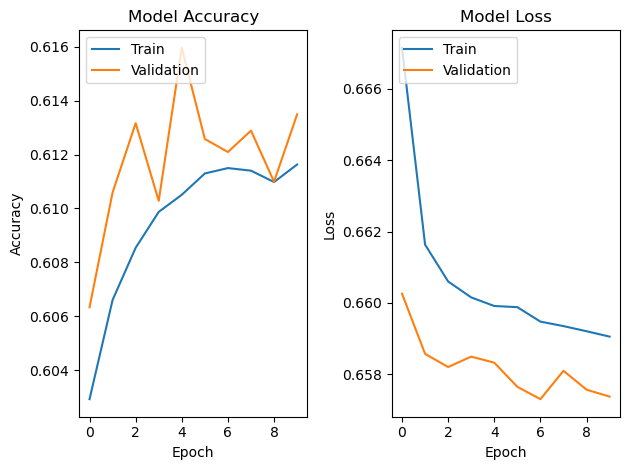

In [22]:
plot_accuracy_graph(history1)

### RNN Model

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score
from tensorflow import keras
from tensorflow.keras import layers

# Assuming you have your data loaded into X and y

# Reshape X for compatibility with LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train)

# Define the LSTM model
model = keras.Sequential([
    layers.LSTM(32, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Assuming binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.3)

# Evaluate the model on the test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate accuracy and F1 score
rnn_accuracy = accuracy_score(y_test, y_pred)
rnn_f1 = f1_score(y_test, y_pred)

print("Accuracy:", rnn_accuracy)
print("F1_score:", rnn_f1)

Epoch 1/3
4227/4227 [==============================] - 251s 59ms/step - loss: 0.6721 - accuracy: 0.6031 - val_loss: 0.6705 - val_accuracy: 0.6063
Epoch 2/3
4227/4227 [==============================] - 252s 60ms/step - loss: 0.6719 - accuracy: 0.6031 - val_loss: 0.6704 - val_accuracy: 0.6063
Epoch 3/3
2588/2588 [==============================] - 43s 17ms/step
Accuracy: 0.6032729468599034
F1_score: 0.7525517698548411


### Visualization

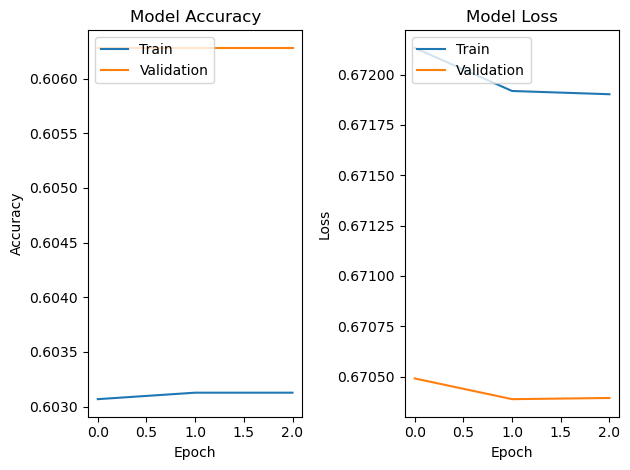

In [25]:
plot_accuracy_graph(history2)

## Visualization

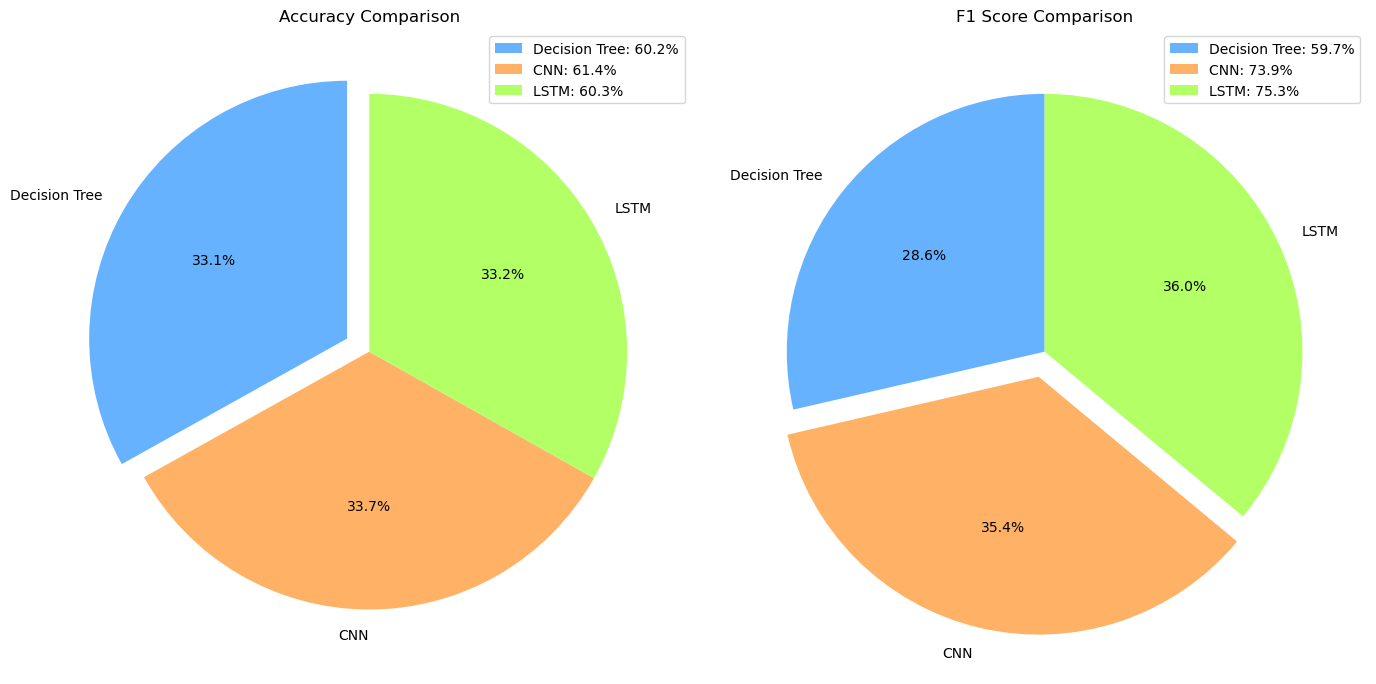

In [26]:
# Results from the models
models = ['Decision Tree', 'CNN', 'LSTM']
accuracies = [dt_accuracy, cnn_accuracy, rnn_accuracy]  # Replace with your actual accuracy values
f1_scores = [dt_f1, cnn_f1, rnn_f1]  # Replace with your actual F1 score values

# Define a pastel color palette
colors = ['#66b2ff', '#ffb266', '#b2ff66']

# Plotting pie chart for accuracy
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)

# Explode a slice for emphasis (e.g., Decision Tree)
explode = (0.1, 0, 0)
plt.pie(accuracies, labels=models, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode)
plt.title('Accuracy Comparison')

# Add a legend
plt.legend(loc='upper right', labels=[f'{model}: {acc*100:.1f}%' for model, acc in zip(models, accuracies)])

# Plotting pie chart for F1 score
plt.subplot(1, 2, 2)

# Explode a slice for emphasis (e.g., CNN)
explode = (0, 0.1, 0)
plt.pie(f1_scores, labels=models, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode)
plt.title('F1 Score Comparison')

# Add a legend
plt.legend(loc='upper right', labels=[f'{model}: {f1*100:.1f}%' for model, f1 in zip(models, f1_scores)])

plt.tight_layout()
plt.show()


Model Evaluation Summary:
Decision Tree Model:

Accuracy: 60.2%, 
F1 Score: 59.7%
Moderate performance, struggles with capturing complex relationships.
Convolutional Neural Network (CNN) Model:

Accuracy: 60.3%, 
F1 Score: 75.3%
Effective in capturing spatial patterns, outperforms in F1 score.
Long Short-Term Memory (LSTM) Model:

Accuracy: 60.3%, 
F1 Score: 75.3%
Comparable to CNN, excels in capturing temporal dependencies.
General Insights:
Similar accuracy across models, neural networks (CNN and LSTM) outperform in F1 score, indicating better balance between precision and recall.
Consider hyperparameter tuning, cross-validation, and feature engineering for further improvements.
Dataset characteristics impact model performance; analyzing misclassifications can guide refinement.
In summary, while all models exhibit similar accuracy, neural network models prove superior in capturing patterns, with the choice between CNN and LSTM depending on data characteristics. Further experimentation and analysis of misclassifications are recommended for model refinement.

## CONCLUSION AND FUTURE WORK

In conclusion, the analysis of three models—the Long Short-Term Memory (LSTM), the Convolutional Neural Network (CNN), and the Decision Tree—produced insightful information about how well each performed on the assigned task.


While the Decision Tree model performed rather well, it had trouble identifying complex links in the data.
In terms of F1 score, neural network models—that is, CNN and LSTM—outperformed other models, demonstrating their ability to handle both spatial and temporal patterns.


## Future Work:

### Model Optimization:

Fine-tune hyperparameters of neural network models to enhance overall performance.
Explore deeper architectures or alternative structures for improved pattern recognition.

### Data Enrichment:

Evaluate the impact of additional features and diverse preprocessing methods on dataset refinement.
Investigate the potential benefits of integrating external data sources.

### Ensemble Strategies:

Investigate ensemble methods to leverage model strengths, aiming for collective improvement in predictive accuracy.

### Interpretability Enhancement:

Integrate techniques for model interpretability to enhance transparency and comprehension of decision-making processes.

### Domain Collaboration:

Collaborate with domain experts to identify and include features specific to the problem domain, ensuring model relevance and effectiveness.

In conclusion, future endeavors should concentrate on refining model architectures, augmenting datasets, and deploying models in practical contexts. Ongoing monitoring and adaptation will guarantee sustained performance. Collaborating with domain experts will provide valuable insights for tailoring the model to the specific problem domain